In [ ]:
import pandas as pd

#Loading the dataset
df = pd.read_csv('/content/merged_output (2).csv')

#Droping columns which are not required for clustering
drop_cols = [
    'state_id', 'district_id', 'subdistrict_id',
    'elevation_num_cells', 'tri_num_cells', 'vcf_num_cells',
    'year'
]
terrain_features = df.drop(columns=drop_cols)

#Checking missing values
print("Missing values per column:\n", terrain_features.isna().sum())

#Dropping rows with missing values
terrain_features_clean = terrain_features.dropna()

#Checking the number of rows dropped
print(f"\nRows before dropping: {len(terrain_features)}")
print(f"Rows after dropping: {len(terrain_features_clean)}")
print(f"Total rows dropped: {len(terrain_features) - len(terrain_features_clean)}")

Missing values per column:
 elevation_mean             20
elevation_median           20
elevation_percentile_5     20
elevation_percentile_25    20
elevation_min              20
elevation_max              20
elevation_std              20
tri_min                    20
tri_max                    20
tri_mean                   20
tri_median                 20
tri_std                    20
vcf_min                     0
vcf_max                     0
vcf_mean                    0
dtype: int64

Rows before dropping: 119380
Rows after dropping: 119360
Total rows dropped: 20


In [ ]:
from sklearn.preprocessing import StandardScaler
import pandas as pd

#Normalizing the data
scaler = StandardScaler()

#Fitting the cleaned terrain features
terrain_scaled = scaler.fit_transform(terrain_features_clean)

#Converting the scaled data back to original column names
terrain_scaled_df = pd.DataFrame(terrain_scaled, columns=terrain_features_clean.columns)

#Previewing the data
print("Scaled Terrain Features (first 5 rows):")
print(terrain_scaled_df.head())

Scaled Terrain Features (first 5 rows):
   elevation_mean  elevation_median  elevation_percentile_5  \
0        7.501607          8.127512                5.561646   
1        7.501607          8.127512                5.561646   
2        7.501607          8.127512                5.561646   
3        7.501607          8.127512                5.561646   
4        7.501607          8.127512                5.561646   

   elevation_percentile_25  elevation_min  elevation_max  elevation_std  \
0                 7.891412       1.152623       8.173122       6.526082   
1                 7.891412       1.152623       8.173122       6.526082   
2                 7.891412       1.152623       8.173122       6.526082   
3                 7.891412       1.152623       8.173122       6.526082   
4                 7.891412       1.152623       8.173122       6.526082   

    tri_min    tri_max  tri_mean  tri_median   tri_std   vcf_min   vcf_max  \
0 -0.209946  16.090807  2.618645    2.607199  3.8269

In [ ]:
from sklearn.decomposition import PCA

#Applying PCA to reduce to 2 dimensions
pca = PCA(n_components=2)

#Fitting and transforming the scaled data
terrain_pca = pca.fit_transform(terrain_scaled)

terrain_pca_df = pd.DataFrame(terrain_pca, columns=['PC1', 'PC2'])

# Previewing the PCA-transformed rows
print("PCA Output (first 5 rows):")
print(terrain_pca_df.head())

PCA Output (first 5 rows):
         PC1       PC2
0  19.406335 -6.227116
1  19.376201 -6.275826
2  19.360509 -6.298598
3  19.378795 -6.270104
4  19.421437 -6.193794


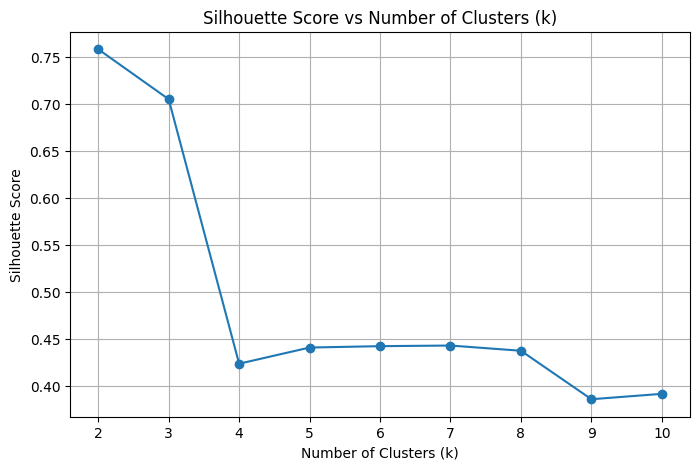

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Range of k
cluster_range = range(2, 11)
silhouette_scores = []

# Trying KMeans for each value of k
for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(terrain_pca_df)
    score = silhouette_score(terrain_pca_df, labels)
    silhouette_scores.append(score)

# Ploting silhouette scores
plt.figure(figsize=(8, 5))
plt.plot(cluster_range, silhouette_scores, marker='o')
plt.title("Silhouette Score vs Number of Clusters (k)")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.show()

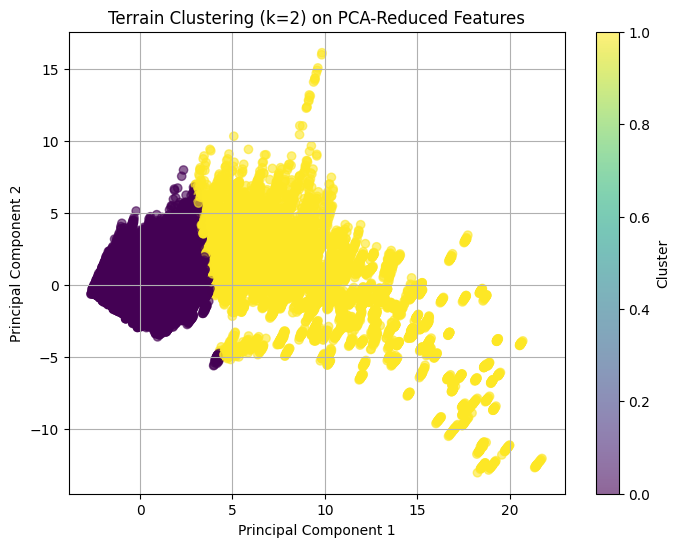

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import pandas as pd

#Applying K-Means clustering with k = 2
kmeans_final = KMeans(n_clusters=2, random_state=42, n_init=10)
cluster_labels = kmeans_final.fit_predict(terrain_pca_df[['PC1', 'PC2']])

#Adding cluster labels to the PCA DataFrame
terrain_pca_df['cluster'] = cluster_labels

#Attaching original region identifiers
region_ids = df[['state_id', 'district_id', 'subdistrict_id']].iloc[terrain_features_clean.index].reset_index(drop=True)

#Combining region info + PCA + cluster label
terrain_clustered = pd.concat([region_ids, terrain_pca_df], axis=1)

#Ploting the clusters
plt.figure(figsize=(8, 6))
plt.scatter(terrain_pca_df['PC1'], terrain_pca_df['PC2'], c=terrain_pca_df['cluster'], cmap='viridis', alpha=0.6)
plt.title("Terrain Clustering (k=2) on PCA-Reduced Features")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True)
plt.colorbar(label="Cluster")
plt.show()

In [ ]:
#attaching cluster labels to original terrain data
terrain_with_cluster = terrain_features_clean.copy()
terrain_with_cluster['cluster'] = terrain_pca_df['cluster'].values

#Analyzing average characteristics by cluster
cluster_summary = terrain_with_cluster.groupby('cluster').agg({
    'elevation_mean': 'mean',
    'elevation_std': 'mean',
    'tri_mean': 'mean',
    'tri_std': 'mean',
    'vcf_mean': 'mean'
}).round(2)

print("Cluster Feature Summary:\n")
print(cluster_summary)

Cluster Feature Summary:

         elevation_mean  elevation_std  tri_mean  tri_std  vcf_mean
cluster                                                            
0                247.78          42.13      5.87      4.5     10.37
1               1678.16         488.96     36.42     17.8     45.34


In [ ]:
terrain_pca_df.to_csv('terrain_clusters.csv', index=False)

print("CSV file 'terrain_clusters.csv' created successfully!")

CSV file 'terrain_clusters.csv' created successfully!
